In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=q5DQnx0QbbGpZz4l-eDYv9smZnwL1eh4AP2HKgSLYwc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g47h3KRBe3uGsVP0HV50Srwt5nrQgAq7_v-dtwdkGELbEOD5A5SO1M

Successfully saved authorization token.


In [ ]:
import os
import glob
import shutil
import time
import json
from pprint import pprint

import numpy as np
import tensorflow as tf
import folium

import gdal
import osr
import matplotlib.pyplot as plt

In [ ]:
def reduce_class_value(feat):
  return feat.set('class', ee.Number(feat.get('class')).subtract(1))


def cloudMask(img):
  return img.updateMask(img.select('BQA').lt(64))
  

def select_landsat(year):
  if (year >= 2013):
    return {
        'bands': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7'],
        'FCCbands': ['B5', 'B4', 'B3'],
        'TextureBand': ['B5'],
        'bandsClassify': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B5_1'],
        'bandsGLCM': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B5_asm', 'B5_contrast', "B5_corr", "B5_var", "B5_idm", "B5_savg", "B5_svar", "B5_sent", "B5_ent", "B5_dvar", "B5_dent", "B5_imcorr1", "B5_imcorr2","B5_maxcorr", "B5_diss",  "B5_inertia", "B5_shade", "B5_prom"],
        'Landsat': 'LANDSAT/LC08/C01/T1'
    }

  if (year >= 1999 and year <= 2002):
    return {
        'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'],
        'TextureBand': ['B4'],
        'bandsClassify': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7','B4_1'],
        'bandsGLCM': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B4_asm', 'B4_contrast',"B4_corr", "B4_var","B4_idm","B4_savg", "B4_svar","B4_sent","B4_ent","B4_dvar","B4_dent","B4_imcorr1", "B4_imcorr2","B4_maxcorr","B4_diss","B4_inertia","B4_shade","B4_prom"],
        'FCCbands': ['B4', 'B3', 'B2'],
        'Landsat': 'LANDSAT/LE07/C01/T1'
    }

  if (year >= 1984 and year <= 1998 or year >=2003 and year <=2012):
    return{
        'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'],
        'bandsClassify': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7','B4_1'],
        'bandsGLCM': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B4_asm', 'B4_contrast',"B4_corr", "B4_var","B4_idm","B4_savg", "B4_svar","B4_sent","B4_ent","B4_dvar","B4_dent","B4_imcorr1", "B4_imcorr2","B4_maxcorr","B4_diss","B4_inertia","B4_shade","B4_prom"],
        'FCCbands': ['B4', 'B3', 'B2'],
        'TextureBand': ['B4'],
        'Landsat': 'LANDSAT/LT05/C01/T1'
    }
  
  if (year == 1983):
    return{
        'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'],
        'bandsClassify': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7','B4_1'],
        'bandsGLCM': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B4_asm', 'B4_contrast',"B4_corr", "B4_var","B4_idm","B4_savg", "B4_svar","B4_sent","B4_ent","B4_dvar","B4_dent","B4_imcorr1", "B4_imcorr2","B4_maxcorr","B4_diss","B4_inertia","B4_shade","B4_prom"],
        'FCCbands': ['B4', 'B3', 'B2'],
        'TextureBand': ['B4'],
        'Landsat': 'LANDSAT/LT04/C01/T1'
    }
  
  if (year >= 1979 and year <= 1982):
    return {
        'bands': ['B4_median', 'B5_median', 'B6_median','B7_median','B6_median_1'],
        'bandsClassify': ['B4_median', 'B5_median', 'B6_median', 'B7_median'],
        'FCCbands': ['B6_median', 'B5_median', 'B4_median'],
        'TextureBand': ['B6_median'],
        'Landsat': 'LANDSAT/LM03/C01/T1'
    }

  if (year >= 1975 and year <= 1978):
    return {
        'bands': ['B4_median', 'B5_median', 'B6_median','B7_median','B6_median_1'],
        'bandsClassify': ['B4_median', 'B5_median', 'B6_median', 'B7_median'],
        'FCCbands': ['B6_median', 'B5_median', 'B4_median'],
        'TextureBand': ['B6_median'],
        'Landsat': 'LANDSAT/LM02/C01/T2'
    }

  if (year >= 1972 and year <= 1974):
    return {
        'bands': ['B4_median', 'B5_median', 'B6_median','B7_median','B6_median_1'],
        'bandsClassify': ['B4_median', 'B5_median', 'B6_median', 'B7_median'],
        'FCCbands': ['B6_median', 'B5_median', 'B4_median'],
        'TextureBand': ['B6_median'],
        'Landsat': 'LANDSAT/LM01/C01/T2'
    }

In [ ]:
def landsat_product(landsat_id):
  if(landsat_id == 'LANDSAT/LM01/C01/T2' or landsat_id == 'LANDSAT/LM02/C01/T2' or landsat_id == 'LANDSAT/LM03/C01/T1'):
    image = ee.ImageCollection(landsat_id).filterDate(str(gtYearBegin) + '-01-01',str(gtYearEnd) + '-12-31').filter(ROI[roi]['doyFilterLandsat']).filterBounds(out_ext).filterMetadata('CLOUD_COVER_LAND', 'less_than', 20).map(cloudMask).reduce(ee.Reducer.median())
    return {
      'image': image,
      'image_int': image.toByte()       
    }
  else:
    image_col = ee.ImageCollection(landsat_id).filterDate(str(gtYearBegin) + '-01-01',str(gtYearEnd) + '-12-31').filter(ROI[roi]['doyFilterLandsat']).filterBounds(out_ext)
    return {
      'region': image_col.geometry().bounds().getInfo(),
      'image': ee.Algorithms.Landsat.simpleComposite(image_col, 50, cloud, 40, True),
      'image_int': ee.Algorithms.Landsat.simpleComposite(image_col, 50, cloud, 40, False)
  }

In [ ]:
def add_indices(params, product):
  
  if(params['Landsat']=='LANDSAT/LC08/C01/T1'):
    swir  = product['image'].select('B6')
    nir   = product['image'].select('B5')
    red   = product['image'].select('B4')
    green = product['image'].select('B3')

    ndvi  = nir.subtract(red).divide(nir.add(red))
    ndbi  = swir.subtract(nir).divide(swir.add(nir))
    bi    = ndbi.subtract(ndvi)
    ndwi  = green.subtract(swir).divide(green.add(swir))

    product['image'] = product['image'].addBands([ndvi, ndbi, bi, ndwi])
    product['image'] = product['image'].rename('B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','ndvi','ndbi','bi','ndwi')

    params['bandsClassify'].extend(['ndvi', 'ndbi', 'bi', 'ndwi'])


  if(params['Landsat'] == 'LANDSAT/LE07/C01/T1'):
    swir  = product['image'].select('B5')
    nir   = product['image'].select('B4')
    red   = product['image'].select('B3')
    green = product['image'].select('B2')

    ndvi  = nir.subtract(red).divide(nir.add(red))
    ndbi  = swir.subtract(nir).divide(swir.add(nir))
    bi    = ndbi.subtract(ndvi)
    ndwi  = green.subtract(swir).divide(green.add(swir))

    product['image'] = product['image'].addBands([ndvi, ndbi, bi, ndwi])
    product['image'] = product['image'].rename('B1','B2','B3','B4','B5','B6_VCID_1','B6_VCID_2','B7','B8','ndvi','ndbi','bi','ndwi')

    params['bandsClassify'].extend(['ndvi', 'ndbi', 'bi', 'ndwi'])
    

  if(params['Landsat'] == 'LANDSAT/LM04/C01/T1' or params['Landsat'] == 'LANDSAT/LT05/C01/T1'):
    swir  = product['image'].select('B5')
    nir   = product['image'].select('B4')
    red   = product['image'].select('B3')
    green = product['image'].select('B2')

    ndvi  = nir.subtract(red).divide(nir.add(red))
    ndbi  = swir.subtract(nir).divide(swir.add(nir))
    bi    = ndbi.subtract(ndvi)
    ndwi  = green.subtract(swir).divide(green.add(swir))

    product['image'] = product['image'].addBands([ndvi, ndbi, bi, ndwi])
    product['image'] = product['image'].rename('B1','B2','B3','B4','B5','B6','B7','ndvi','ndbi','bi','ndwi')

    params['bandsClassify'].extend(['ndvi', 'ndbi', 'bi', 'ndwi'])


  if(params['Landsat'] == 'LANDSAT/LM01/C01/T2' or params['Landsat'] == 'LANDSAT/LM02/C01/T2' or params['Landsat'] == 'LANDSAT/LM03/C01/T1'):
    swir = product['image'].select('B6_median')
    nir = product['image'].select('B6_median')
    red = product['image'].select('B5_median')

    ndvi = nir.subtract(red).divide(nir.add(red))

    product['image'] = product['image'].addBands(ndvi)
    product['image'] = product['image'].rename('B4_median','B5_median','B6_median','B7_median','BQA_median','ndvi')

    params['bandsClassify'].append('ndvi')
  

In [ ]:
ROI = [
       {'cityName': 'Laguna Lake', 'LatMax': 14.5758304600000006, 'LatMin': 13.9641799899999999, 'LonMax': 121.6324386600000054, 'LonMin': 121.0053329499999961, 'yearBegin':2019, 'yearEnd':2019, 'doyFilter':ee.Filter.And(ee.Filter.greaterThanOrEquals('doy',  1), ee.Filter.lessThanOrEquals('doy',  366)), 'doyFilterLandsat': ee.Filter.dayOfYear(1,366)},
]

In [ ]:
ts = time.time()
timestamp = int(ts)

roi= ''
kernel = ee.Kernel.gaussian(1)
out_ext = ''

cloud = 30
spatial_resolution = 120
n_sample = 10000
distance = 370000

base_distance = 5000
patch_size = 256
buffer_distance = base_distance * (round((spatial_resolution * 0.5 * patch_size)/base_distance) +1)

In [ ]:
ref_point = ee.FeatureCollection('users/rhtkhati/gt-pt-2500')
ref_point = ref_point.map(reduce_class_value)

In [ ]:
for roi in range(0, len(ROI), 1):
  city_name = ROI[roi]['cityName']
  year_begin = ROI[roi]['yearBegin']
  year_end = ROI[roi]['yearEnd']

  USER_NAME = 'rohit'
  IMAGE_FILE_PREFIX = city_name + '_' + str(year_begin) + '_' + str(year_end)
  FOLDER_NAME = USER_NAME + '_' + IMAGE_FILE_PREFIX

  for year in range(year_begin, year_end+1, 1):
    nSampleClass = []
    out_ext = ee.Geometry.Rectangle([ ROI[roi]['LonMin'], ROI[roi]['LatMin'], ROI[roi]['LonMax'], ROI[roi]['LatMax']])
    out_ext_center = out_ext.centroid()

    out_ext_buffer = out_ext.buffer(buffer_distance).bounds()

    center_lat = out_ext_center.getInfo()['coordinates'][1]
    center_lon = out_ext_center.getInfo()['coordinates'][0]

    landsat_params = select_landsat(year_begin)

    gtYearBegin = year_begin
    gtYearEnd = year_end


    product = landsat_product(landsat_params['Landsat'])
    
    LABEL_DATA = ref_point.filter(ee.Filter.And(ee.Filter.greaterThanOrEquals('year', gtYearBegin), ee.Filter.lessThanOrEquals('year', gtYearEnd), ROI[roi]['doyFilter']))
    LABEL_DATA = LABEL_DATA.filterBounds(product['region'])

    add_indices(landsat_params, product)

    gt_image = product['image']
    gt_image_int = product['image_int']
    gt_image_texture = gt_image.addBands(gt_image_int.select(landsat_params['TextureBand']).entropy(kernel))

    out_image = product['image'].clip(out_ext_buffer)
    out_image_int = product['image_int'].clip(out_ext_buffer)
    out_image_texture = out_image.addBands(out_image_int.select(landsat_params['TextureBand']).entropy(kernel))

In [ ]:
mapid = out_image_texture.getMapId({'bands': ['B5', 'B4', 'B3'], 'min': 0, 'max': 0.3})
# mapid = out_image_texture.getMapId({'bands': ['B4_median', 'B5_median', 'B6_median'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[center_lat, center_lon]) 
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Out Image Texture',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
BANDS = landsat_params['bandsClassify']
LABEL = 'class'
N_CLASSES = 4

FEATURE_NAMES = list(BANDS)
FEATURE_NAMES.append(LABEL)

In [ ]:
MY_DRIVE_PATH = '/content/drive/MyDrive'
FOLDER_PATH = MY_DRIVE_PATH + '/' + FOLDER_NAME
SHARED_DRIVE_PATH = '/content/drive/Shareddrives/Miyazaki Lab./Laguna Lake NN/'

TRAIN_FILE_PREFIX = 'Training_' + str(timestamp)
TEST_FILE_PREFIX = 'Testing_' + str(timestamp)

file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH =  MY_DRIVE_PATH + '/' + FOLDER_NAME + '/sample/' +TRAIN_FILE_PREFIX + file_extension
TEST_FILE_PATH = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/sample/' + TEST_FILE_PREFIX + file_extension

OUTPUT_IMAGE_TFR = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/'+ IMAGE_FILE_PREFIX+'.TFRecord'
OUTPUT_IMAGE_TIF = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/'+ IMAGE_FILE_PREFIX+'.tif'

EXPORT_REGION = out_ext
OUTPUT_ASSET_ID = 'users/' + USER_NAME + '/demo'

In [ ]:
sample = gt_image_texture.sampleRegions(
    collection = LABEL_DATA,
    properties = [LABEL],
    scale = spatial_resolution,
).randomColumn()

In [ ]:
training = sample.filter(ee.Filter.lt('random', 0.8))
testing = sample.filter(ee.Filter.gte('random', 0.8))

pprint({'training': training.first().getInfo()})
pprint({'testing': testing.first().getInfo()})

{'training': {'geometry': None,
              'id': '0001000000000003be85_0',
              'properties': {'B1': 0.14806249737739563,
                             'B10': 299.3385925292969,
                             'B11': 295.4011535644531,
                             'B2': 0.13019590079784393,
                             'B3': 0.11521103978157043,
                             'B4': 0.10548434406518936,
                             'B5': 0.1406380534172058,
                             'B5_1': 2.043191909790039,
                             'B6': 0.08737176656723022,
                             'B7': 0.05263849347829819,
                             'B8': 0.11232209950685501,
                             'B9': 0.0017208431381732225,
                             'bi': -0.3764441907405853,
                             'class': 0,
                             'ndbi': -0.2336139976978302,
                             'ndvi': 0.14283019304275513,
                             'ndwi': 0

In [ ]:
training_task = ee.batch.Export.table.toDrive(
  collection=training,
  description='Training Export',
  folder=FOLDER_NAME,
  fileNamePrefix=TRAIN_FILE_PREFIX,
  fileFormat='TFRecord',
  selectors=FEATURE_NAMES)

testing_task = ee.batch.Export.table.toDrive(
  collection=testing,
  description='Testing Export',
  folder=FOLDER_NAME,
  fileNamePrefix=TEST_FILE_PREFIX,
  fileFormat='TFRecord',
  selectors=FEATURE_NAMES)

In [ ]:
training_task.start()
testing_task.start()

In [ ]:
while training_task.active():
  print('Polling for task (id: {}).'.format(training_task.id))
  time.sleep(20)
print('Done with training export.')

while testing_task.active():
  print('Polling for task (id: {}).'.format(testing_task.id))
  time.sleep(20)
print('Done with testing export.')

Polling for task (id: OHHTIXPRYYGDI2FR4WT3FUNX).
Polling for task (id: OHHTIXPRYYGDI2FR4WT3FUNX).
Polling for task (id: OHHTIXPRYYGDI2FR4WT3FUNX).
Polling for task (id: OHHTIXPRYYGDI2FR4WT3FUNX).
Done with training export.
Done with testing export.


In [ ]:
time.sleep(5)
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
src_dir = MY_DRIVE_PATH + '/' + FOLDER_NAME
src_files = os.listdir(src_dir)

dest_dir = os.path.join(src_dir, 'sample')

os.makedirs(dest_dir, exist_ok = True)

for file in src_files:
    shutil.move(os.path.join(src_dir, file), dest_dir)

In [ ]:
print('Found training file.' if tf.io.gfile.exists(TRAIN_FILE_PATH) 
    else 'No training file found.')

print('Found testing file.' if tf.io.gfile.exists(TEST_FILE_PATH) 
    else 'No testing file found.')

Found training file.
Found testing file.


In [ ]:
train_dataset = tf.data.TFRecordDataset(TRAIN_FILE_PATH, compression_type='GZIP')
test_dataset = tf.data.TFRecordDataset(TEST_FILE_PATH, compression_type='GZIP')

print(iter(train_dataset).next())
print(iter(test_dataset).next())

tf.Tensor(b'\n\xcb\x01\n\x0e\n\x02B2\x12\x08\x12\x06\n\x04\xfdh\xfc=\n\x0e\n\x02B3\x12\x08\x12\x06\n\x048C\xe6=\n\x0e\n\x02B4\x12\x08\x12\x06\n\x04J\xbd\xd4=\n\x0e\n\x02B5\x12\x08\x12\x06\n\x04\xbc\t\x97>\n\x0e\n\x02B6\x12\x08\x12\x06\n\x04fyA>\n\x0e\n\x02B7\x12\x08\x12\x06\n\x04:\xe8\xeb=\n\x10\n\x04B5_1\x12\x08\x12\x06\n\x04T\x9f\x0c@\n\x10\n\x04ndvi\x12\x08\x12\x06\n\x04\x02S\xf5>\n\x10\n\x04ndbi\x12\x08\x12\x06\n\x04\xeai`\xbe\n\x0e\n\x02bi\x12\x08\x12\x06\n\x04\xfc\xc32\xbf\n\x10\n\x04ndwi\x12\x08\x12\x06\n\x04\x14\xfa\x81\xbe\n\x11\n\x05class\x12\x08\x12\x06\n\x04\x00\x00\x00\x00', shape=(), dtype=string)
tf.Tensor(b'\n\xcb\x01\n\x0e\n\x02B2\x12\x08\x12\x06\n\x04\x16\xb3\x0f>\n\x0e\n\x02B3\x12\x08\x12\x06\n\x04\xbf\xbf\xf6=\n\x0e\n\x02B4\x12\x08\x12\x06\n\x04\x12i\xe8=\n\x0e\n\x02B5\x12\x08\x12\x06\n\x04K\xa1\x06>\n\x0e\n\x02B6\x12\x08\x12\x06\n\x04S \xc9=\n\x0e\n\x02B7\x12\x08\x12\x06\n\x04\xb3\x0f\x89=\n\x10\n\x04B5_1\x12\x08\x12\x06\n\x04\xa8\xc3\x02@\n\x10\n\x04ndvi\x12\x08\x

In [ ]:
columns = [
           tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

features_dict = dict(zip(FEATURE_NAMES, columns))

pprint(features_dict)

{'B2': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B5_1': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B6': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'bi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'class': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'ndbi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'ndvi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'ndwi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)}


In [ ]:
def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, features_dict)
  labels = parsed_features.pop(LABEL)
  return parsed_features, tf.cast(labels, tf.int32)

parsed_trainset = train_dataset.map(parse_tfrecord, num_parallel_calls=5)
parsed_testset = test_dataset.map(parse_tfrecord, num_parallel_calls=5)

pprint(iter(parsed_trainset))
pprint(iter(parsed_testset))

In [ ]:
batch_size = 100

def to_tuple(inputs, label):
  return (tf.transpose(list(inputs.values())), tf.one_hot(indices=label, depth=N_CLASSES))

input_dataset = parsed_trainset.map(to_tuple).batch(batch_size)
validate_dataset = parsed_testset.map(to_tuple).batch(batch_size)


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(N_CLASSES, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mse']
)

In [ ]:

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

log_d = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/' + 'model'
os.makedirs(log_d, exist_ok=True)

def build_callbacks():
    checkpointer = ModelCheckpoint(filepath = log_d, verbose=0, save_best_only=True, monitor='val_loss')
    callbacks = [checkpointer]
    return callbacks
history = model.fit(x=input_dataset,validation_data=(validate_dataset), epochs=20, callbacks=build_callbacks())

Epoch 1/20
160/160 [==============================] - 4s 16ms/step - loss: 1.3734 - accuracy: 0.3564 - mse: 0.1859 - val_loss: 1.3025 - val_accuracy: 0.4832 - val_mse: 0.1771
INFO:tensorflow:Assets written to: /content/drive/MyDrive/rohit_Laguna Lake_2019_2019/model/assets
Epoch 2/20
160/160 [==============================] - 2s 14ms/step - loss: 1.3108 - accuracy: 0.5452 - mse: 0.1782 - val_loss: 1.1519 - val_accuracy: 0.7127 - val_mse: 0.1569
INFO:tensorflow:Assets written to: /content/drive/MyDrive/rohit_Laguna Lake_2019_2019/model/assets
Epoch 3/20
160/160 [==============================] - 2s 13ms/step - loss: 1.1560 - accuracy: 0.5824 - mse: 0.1574 - val_loss: 0.8708 - val_accuracy: 0.7351 - val_mse: 0.1159
INFO:tensorflow:Assets written to: /content/drive/MyDrive/rohit_Laguna Lake_2019_2019/model/assets
Epoch 4/20
160/160 [==============================] - 2s 14ms/step - loss: 0.8573 - accuracy: 0.6028 - mse: 0.1146 - val_loss: 0.6561 - val_accuracy: 0.7371 - val_mse: 0.0894
INF

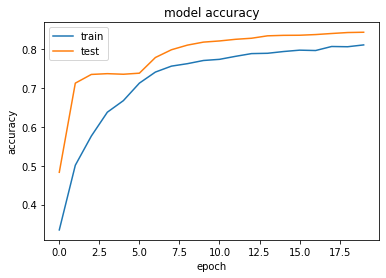

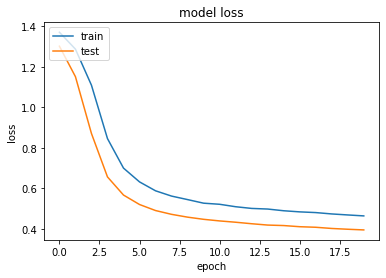

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
 model.evaluate(validate_dataset)

41/41 [==============================] - 0s 9ms/step - loss: 0.3939 - accuracy: 0.8438 - mse: 0.0581


[0.39388570189476013, 0.8437578082084656, 0.0581221766769886]

In [ ]:
image_export_options = {
    'patchDimensions': [patch_size, patch_size],
    'maxFileSize': 104857600,
    'compressed': True
}

image_task = ee.batch.Export.image.toDrive(
  image=out_image_texture,
  description='Image Export',
  fileNamePrefix= IMAGE_FILE_PREFIX,
  folder= FOLDER_NAME,
  scale=spatial_resolution,
  fileFormat='TFRecord',
  region=out_ext_buffer,
  formatOptions=image_export_options,
)

image_task.start()

In [ ]:
while image_task.active():
  print('Polling for task (id: {}).'.format(image_task.id))
  time.sleep(20)
print('Done with image export.')

Polling for task (id: MVVDQJCRWXULMD62HHVGZGCK).
Polling for task (id: MVVDQJCRWXULMD62HHVGZGCK).
Polling for task (id: MVVDQJCRWXULMD62HHVGZGCK).
Polling for task (id: MVVDQJCRWXULMD62HHVGZGCK).
Polling for task (id: MVVDQJCRWXULMD62HHVGZGCK).
Done with image export.


In [ ]:
time.sleep(10)
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
tfrecord_list = glob.glob(MY_DRIVE_PATH +'/' + FOLDER_NAME + '/' + '*.tfrecord.gz')
tfrecord_list.sort()
print(tfrecord_list)

json_list = glob.glob(MY_DRIVE_PATH +'/' + FOLDER_NAME + '/' + '*.json')
print(json_list)

['/content/drive/MyDrive/rohit_Laguna Lake_2019_2019/demo_image-00000.tfrecord.gz']
['/content/drive/MyDrive/rohit_Laguna Lake_2019_2019/demo_image-mixer.json']


In [ ]:
with open(json_list[0], "r") as read_file:
   mixer = json.load(read_file)

mixer

{'patchDimensions': [256, 256],
 'patchesPerRow': 4,
 'projection': {'affine': {'doubleMatrix': [0.0008084837557075694,
    0.0,
    120.8650875432588,
    0.0,
    -0.0008084837557075694,
    14.711170418854932]},
  'crs': 'EPSG:4326'},
 'totalPatches': 16}

In [ ]:
patch_width = mixer['patchDimensions'][0]
patch_height = mixer['patchDimensions'][1]
patches = mixer['totalPatches']
patch_dimensions_flat = [patch_width*patch_height, 1]

image_columns = [
                tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32) for k in BANDS
]

image_features_dict = dict(zip(BANDS, image_columns))

image_dataset = tf.data.TFRecordDataset(tfrecord_list, compression_type='GZIP')


In [ ]:
def parse_image(example_proto):
  return tf.io.parse_single_example(example_proto, image_features_dict)

In [ ]:
image_dataset = image_dataset.map(parse_image, num_parallel_calls=5)

image_dataset = image_dataset.flat_map(
    lambda features: tf.data.Dataset.from_tensor_slices(features)
)

image_dataset = image_dataset.map(
  lambda data_dict: (tf.transpose(list(data_dict.values())), )
)

image_dataset = image_dataset.batch(patch_width * patch_height)

In [ ]:
predictions = model.predict(image_dataset, steps=patches, verbose=1)
print(predictions[0])

16/16 [==============================] - 52s 3s/step
[[0.675144   0.07726908 0.14548449 0.10210237]]


In [ ]:
writer = tf.io.TFRecordWriter(OUTPUT_IMAGE_TFR)

patch = [[]]
cur_patch = 1
for prediction in predictions:
  patch[0].append(tf.argmax(prediction, 1))

  if (len(patch[0])==patch_width*patch_height):
    print('Done with Patch ' + str(cur_patch) + ' of ' + str(patches) + '...')
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'prediction': tf.train.Feature(
                    int64_list=tf.train.Int64List(
                        value=patch[0]
                    )
                )
            }
        )
    )

    writer.write(example.SerializeToString())
    patch=[[]]
    cur_patch +=1
  
writer.close()

Done with Patch 1 of 16...
Done with Patch 2 of 16...
Done with Patch 3 of 16...
Done with Patch 4 of 16...
Done with Patch 5 of 16...
Done with Patch 6 of 16...
Done with Patch 7 of 16...
Done with Patch 8 of 16...
Done with Patch 9 of 16...
Done with Patch 10 of 16...
Done with Patch 11 of 16...
Done with Patch 12 of 16...
Done with Patch 13 of 16...
Done with Patch 14 of 16...
Done with Patch 15 of 16...
Done with Patch 16 of 16...


In [ ]:
record_iterator = tf.compat.v1.python_io.tf_record_iterator(path=OUTPUT_IMAGE_TFR)

n_row = patches/mixer['patchesPerRow']
n_col = mixer['patchesPerRow']
current_row = 0
current_col = 0
counter = 0

for string_record in record_iterator:
  example = tf.train.Example()
  example.ParseFromString(string_record)
  values = np.array(example.features.feature['prediction'].int64_list.value).reshape(patch_width, patch_height).astype(np.int8)

  if (current_col==0):
    horizontal_strip = values
  else:
    horizontal_strip = np.concatenate([horizontal_strip, values], axis=1)
  current_col += 1

  if (current_col == n_col):
    if (current_row==0):
      image = horizontal_strip
    else:
      image = np.concatenate([image, horizontal_strip], axis=0)
      horizontal_strip = []

    current_row +=1
    current_col = 0
    print(counter)
  counter +=1
print(counter)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
3
7
11
15
16


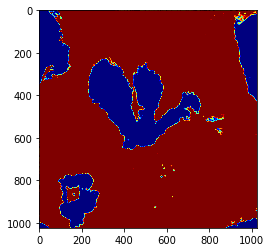

In [ ]:
imgplot = plt.imshow(image, cmap=plt.get_cmap('jet'), vmin=0, vmax=1)
plt.show()

In [ ]:
affine = mixer['projection']['affine']['doubleMatrix']
geotransform = (affine[2], affine[0], affine[1], affine[5], affine[3], affine[4])
crs = int(mixer['projection']['crs'][-4:])
print(affine)
print(geotransform)
print(crs)

[0.0008084837557075694, 0.0, 120.8650875432588, 0.0, -0.0008084837557075694, 14.711170418854932]
(120.8650875432588, 0.0008084837557075694, 0.0, 14.711170418854932, 0.0, -0.0008084837557075694)
4326


In [ ]:
ny, nx = image.shape
dst_ds = gdal.GetDriverByName('GTiff').Create(OUTPUT_IMAGE_TIF, nx, ny, 1, gdal.GDT_Byte)
dst_ds.SetGeoTransform(tuple(geotransform))
srs = osr.SpatialReference()
srs.ImportFromEPSG(crs)
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(image)
dst_ds.FlushCache()
dst_ds = None

print("Exorting " + OUTPUT_IMAGE_TIF + " completed.")

Exorting /content/drive/MyDrive/rohit_Laguna Lake_2019_2019/Laguna Lake_2019_2019.tif completed.


In [ ]:
fcc_image = out_image.select(landsat_params['FCCbands'])
fcc_prefix = city_name + '_' + str(year_begin) + '_' + str(year_end)+'_fcc'

fcc_task = ee.batch.Export.image.toDrive(**{
    'image': fcc_image,
    'description': fcc_prefix,
    'folder': FOLDER_NAME,
    'fileNamePrefix': fcc_prefix,
    'scale': spatial_resolution,
    'region': out_ext
})
fcc_task.start()

In [ ]:
while fcc_task.active():
  print('Polling for task (id: {}).'.format(fcc_task.id))
  time.sleep(20)
print('Done with fcc image export.')

Polling for task (id: RSOTNVYWL63DUHIOOHIRF225).
Polling for task (id: RSOTNVYWL63DUHIOOHIRF225).
Polling for task (id: RSOTNVYWL63DUHIOOHIRF225).
Done with fcc image export.


In [ ]:
time.sleep(5)
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
lc_dir = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/lc_map'
fcc_path = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/'+ fcc_prefix+'.tif'
ref_dir = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/ref_map'

os.makedirs(lc_dir, exist_ok = True)
os.makedirs(ref_dir, exist_ok = True)

shutil.move(OUTPUT_IMAGE_TIF, lc_dir)
shutil.move(OUTPUT_IMAGE_TFR, lc_dir)
shutil.move(fcc_path, ref_dir)

'/content/drive/MyDrive/rohit_Laguna Lake_2019_2019/ref_map/Laguna Lake_2019_2019_fcc.tif'

In [ ]:
drive.mount('/content/drive', force_remount=True)
shutil.move(FOLDER_PATH, SHARED_DRIVE_PATH)

Mounted at /content/drive


'/content/drive/Shareddrives/Miyazaki Lab./Laguna Lake NN/rohit_Laguna Lake_2019_2019'